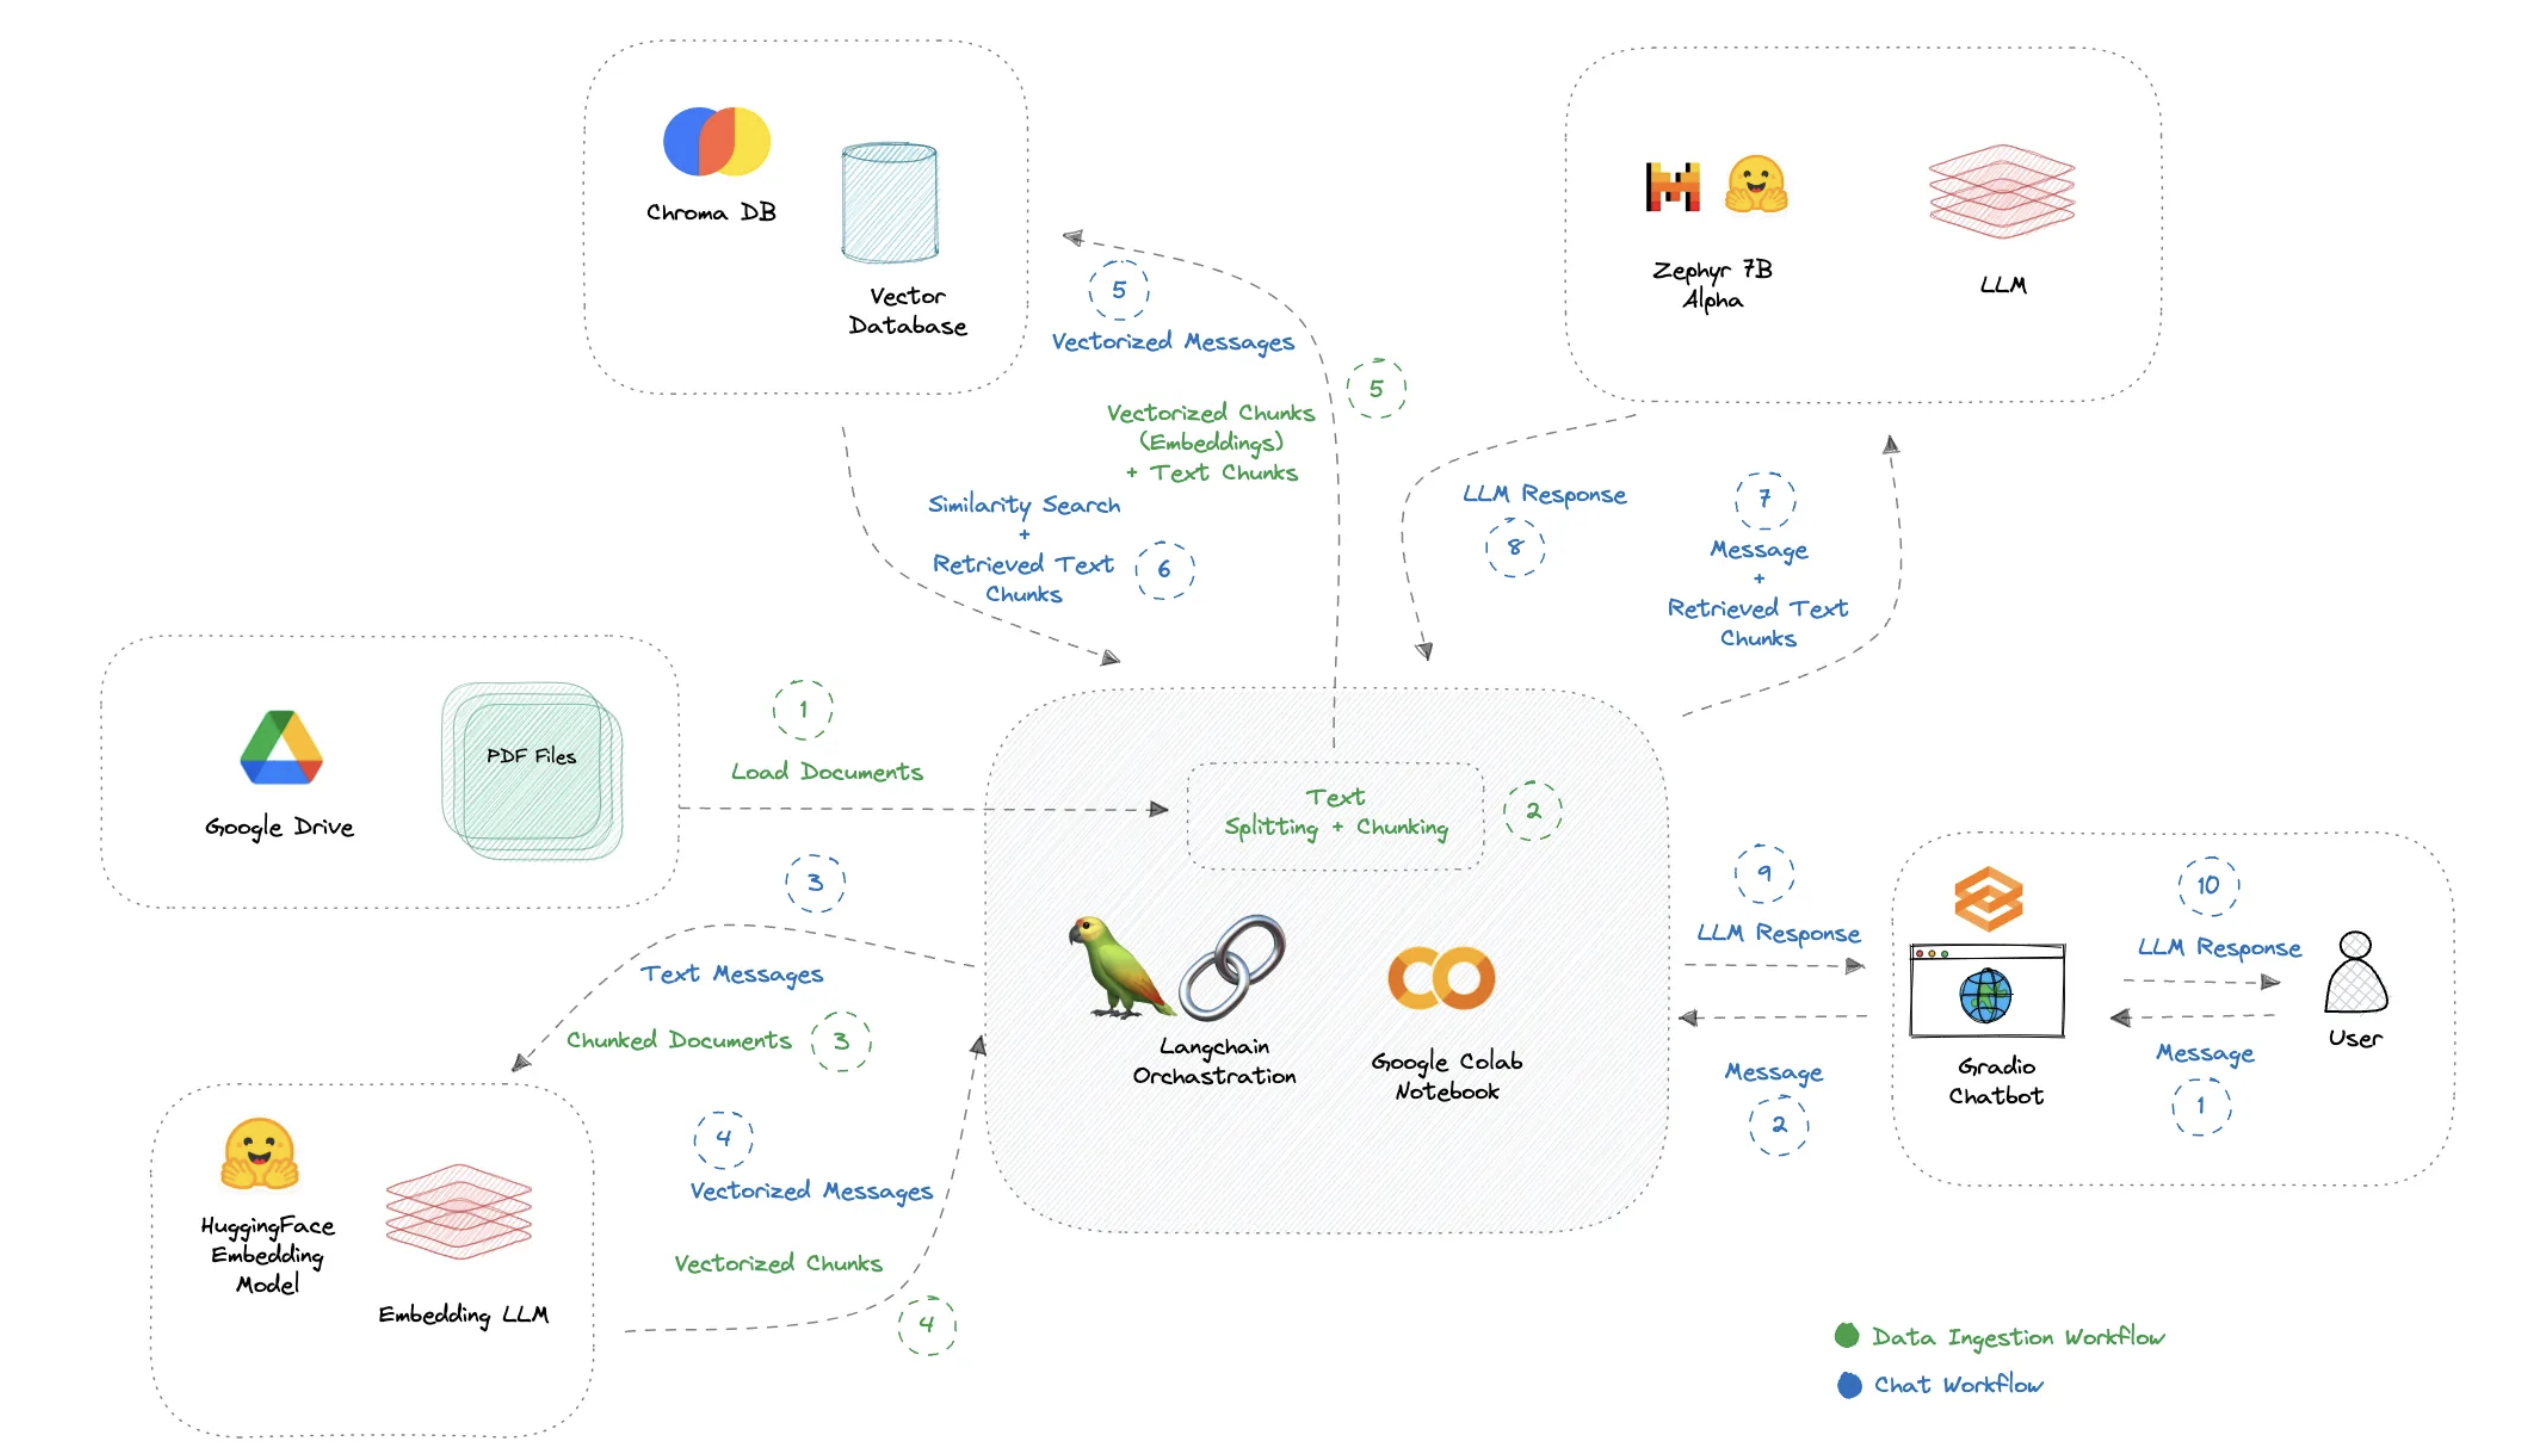

In [ ]:
#install required packages
!pip install -q kaleido cohere openai tiktoken transformers peft  accelerate bitsandbytes safetensors sentencepiece streamlit chromadb langchain sentence-transformers gradio pypdf


In [ ]:
# fixing unicode error in google colab
import locale
locale.getpreferredencoding = lambda: "UTF-8"


In [ ]:
# import dependencies
# import os
# import chromadb
# from langchain.document_loaders import TextLoader


# Data - PDF management
#### -> Data input: Pdf
#### -> Data(1) output: Load Documents = "documents"

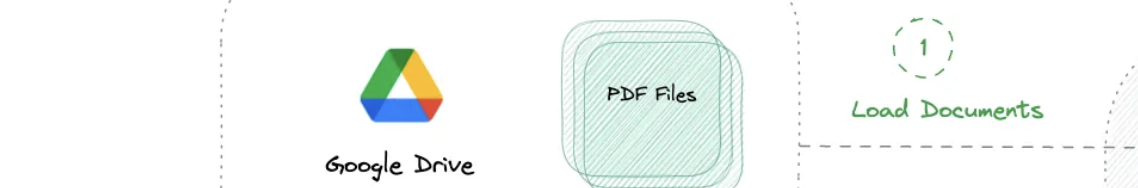

In [ ]:
from google.colab import drive
from langchain.document_loaders import PyPDFDirectoryLoader

# mount google drive and specify folder path
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/coexpert/data'

# load pdf files
loader = PyPDFDirectoryLoader(folder_path)
documents = loader.load()


# Data Preprocessing
#### -> Data input: Documents from Data(1) output
#### -> Data (2) output: Text Splitting + Chunking = "all_splits"

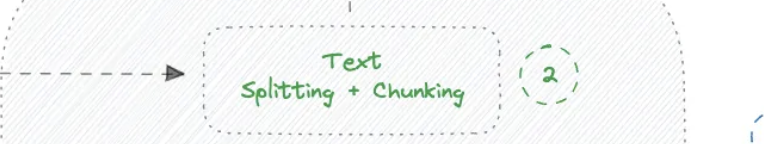

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# split the documents in small chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100) #Change the chunk_size and chunk_overlap as needed
all_splits = text_splitter.split_documents(documents)


# Data Embedding
#### -> Data(3) input: Chunked documents = Data(2) output
#### -> Chat(3) input: Text Messages _through_ "retriever" from "create_conversation"
#### -> Data(4) output: Vectorized Chunks = "embeddings"
#### -> Chat(4) output: Vectorized Messages _through_ "retriever" from "create_conversation"

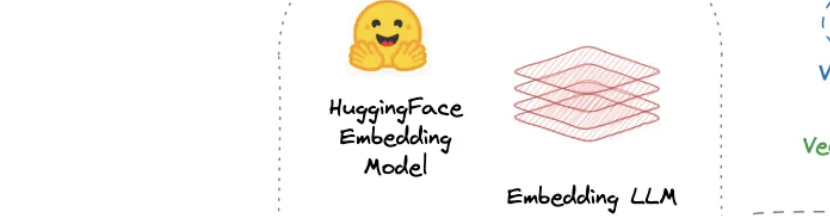

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings

# specify embedding model (using huggingface sentence transformer)
embedding_model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {"device": "cuda"}
embeddings = HuggingFaceEmbeddings(
    model_name=embedding_model_name, model_kwargs=model_kwargs)


# Data & Chat Vector Management (Storage & Similarities)
#### -> Data(5) input:  Vectorized Chunks (Embeddings) from Data(4) ouput + Text chunks from Data(2) output = "vectordb"
#### -> Chat(5) input: Vectorized Messages _through_ "retriever" from "create_conversation"
#### -> Chat(6) output: Similiarity Search + Retrieve Text Chunks = "retriever"


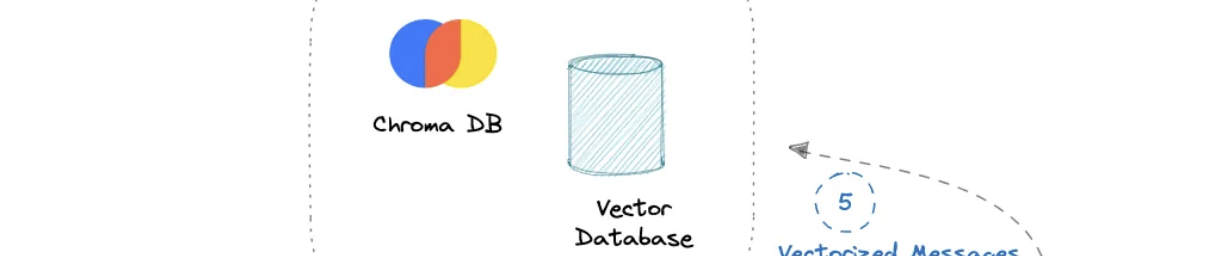

In [ ]:
from langchain.vectorstores import Chroma

# embed document chunks
vectordb = Chroma.from_documents(documents=all_splits, embedding=embeddings, persist_directory="chroma_db")

# specify the retriever
retriever = vectordb.as_retriever()


# Chat Modelling
#### -> Chat(7) input: Message + Retrieve Text Chunks _through_ "create_conversation"
#### -> Chat(8) output: LLM Response = "llm"


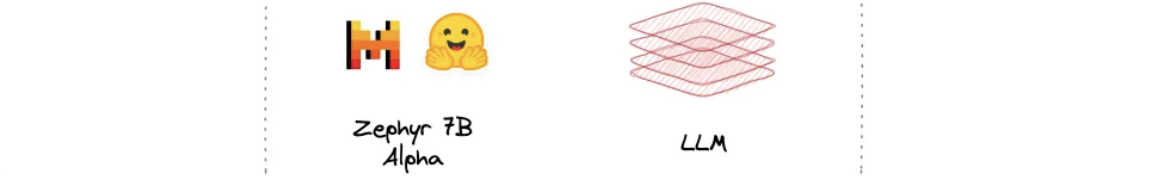

In [ ]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

# specify model huggingface mode name
model_name = "anakin87/zephyr-7b-alpha-sharded"

######## other models:
# "Trelis/Llama-2-7b-chat-hf-sharded-bf16"
# "bn22/Mistral-7B-Instruct-v0.1-sharded"
# "HuggingFaceH4/zephyr-7b-beta"

# function for loading 4-bit quantized model
def load_quantized_model(model_name: str):
    """
    :param model_name: Name or path of the model to be loaded.
    :return: Loaded quantized model.
    """
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        load_in_4bit=True,
        torch_dtype=torch.bfloat16,
        quantization_config=bnb_config
    )
    return model


In [ ]:
from transformers import AutoTokenizer

# fucntion for initializing tokenizer
def initialize_tokenizer(model_name: str):
    """
    Initialize the tokenizer with the specified model_name.

    :param model_name: Name or path of the model for tokenizer initialization.
    :return: Initialized tokenizer.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.bos_token_id = 1  # Set beginning of sentence token id
    return tokenizer


In [ ]:
# load model
model = load_quantized_model(model_name)

# initialize tokenizer
tokenizer = initialize_tokenizer(model_name)

# specify stop token ids
stop_token_ids = [0] # where is it used?


In [ ]:
from transformers import pipeline
from langchain.llms import HuggingFacePipeline
from langchain import HuggingFacePipeline # why 2 imports?
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory

# build huggingface pipeline for using zephyr-7b-alpha
pipeline = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        use_cache=True,
        device_map="auto",
        max_length=2048,
        do_sample=True,
        top_k=5,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
)

# specify the llm
llm = HuggingFacePipeline(pipeline=pipeline)


# Chat Interface-API
#### -> Chat(1&2) input: Message _through_ "create_conversation"
#### -> Chat(9&10) output: LLM Response _through_ "create_conversation"

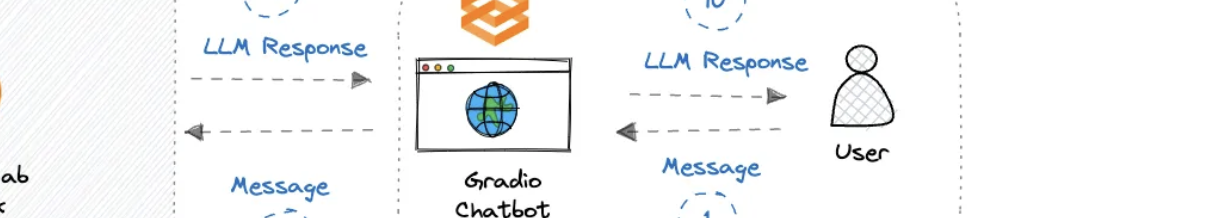

In [ ]:

# build conversational retrieval chain with memory (rag) using langchain
def create_conversation(query: str, chat_history: list) -> tuple:
    try:

        memory = ConversationBufferMemory(
            memory_key='chat_history',
            return_messages=False
        )
        qa_chain = ConversationalRetrievalChain.from_llm(
            llm=llm,
            retriever=retriever,
            memory=memory,
            get_chat_history=lambda h: h,
        )

        result = qa_chain({'question': query, 'chat_history': chat_history})
        chat_history.append((query, result['answer']))
        return '', chat_history

    except Exception as e:
        chat_history.append((query, e))
        return '', chat_history


In [ ]:
import gradio as gr

# build gradio ui
with gr.Blocks() as demo:

    chatbot = gr.Chatbot(label='Chat with your data (Zephyr 7B Alpha)')
    msg = gr.Textbox()
    clear = gr.ClearButton([msg, chatbot])

    msg.submit(create_conversation, [msg, chatbot], [msg, chatbot])

demo.launch()
